<a href="https://colab.research.google.com/github/junhyunpark0126/deeplearning-digit-classifier/blob/main/deeplearning_digit_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Setup Jargon


## Import the required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from google.colab import drive
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

## Set up GPU capabilities

The cell below sets up a CUDA device to use with torch.


In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0+cu118
cuda:0


In [ ]:
device

device(type='cuda', index=0)

# **Part 1:** Data Preprocessing and Preparation for Modeling in `PyTorch`

We will be classifying images using a somewhat famous dataset from Stanford.

Dataset Citation:

Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011.

The dataset is called Street View House Numbers (or SVHN). The dataset consists of images of **house numbers**, taken from Google Street View. There are 10 classes, one for each digit (0-9).


For more information about the dataset, please look [here](http://ufldl.stanford.edu/housenumbers/)

There are 73,257 sample digits for training, 26,032 samples for testing, and 531131 extra samples.

We will be using this dataset to train 3 different models:

1.   Logistic Regression
2.   Feedforward (Fully-Connected) Neural Network (FNN)
3.   Convolutional Neural Network (CNN)

And analyze the difference between these models by looking at the test accuracy and loss.

### 1.1.1 Instantiate Dataset (for train/test dataset)



In [ ]:
scale = 32

transform = transforms.Compose([
    transforms.Resize((scale, scale)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Now that we have defined the tranforms we are going to apply to the dataset, let's instantiate `Dataset` objects for both the training and testing sets using predefined PyTorch Dataset.

In [ ]:
import torchvision.datasets as datasets
train_dataset = datasets.SVHN(root='./data', split='train', transform = transform, download=True)
test_dataset = datasets.SVHN(root='./data', split='test', transform = transform, download=True)

100%|██████████| 182040794/182040794 [00:11<00:00, 16010192.68it/s]


100%|██████████| 64275384/64275384 [00:05<00:00, 11093731.97it/s]


In [ ]:
# Check the sizes of the training and test dataset and verify
# they match the description at the beginning
print(len(train_dataset))
print(len(test_dataset))

73257
26032


## 1.2 Summarizing our Dataset

### 1.2.1 Looking at the distribution of labels

In [ ]:
# Use the original train dataset to obtain the number of label classes train data
labels = []
for image, label in train_dataset:
  labels.append(label)
train_num_labels = len(set(labels))

# Create dictionary for train dataset
train_dataset_dict = Counter(labels)

# Create training data dataloader
train_loader_bar_plot = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=0)

print(train_dataset_dict)

Counter({1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 0: 4948, 9: 4659})


In [ ]:
# Use the original test dataset to obtain the number of label classes in test data
labels = []
for image, label in test_dataset:
  labels.append(label)
test_num_labels = len(set(labels))

# Create dictionary for test dataset
test_dataset_dict = Counter(labels)

# Create testing data dataloader
test_loader_bar_plot = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

print(test_dataset_dict)

Counter({1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 7: 2019, 6: 1977, 0: 1744, 8: 1660, 9: 1595})


### 1.2.2 Visualize through bar charts

Now we are going to visualize the distribution of labels using bar charts for both training and testing set which we store the distributions in their respective dictionary objects in section 1.2.1.

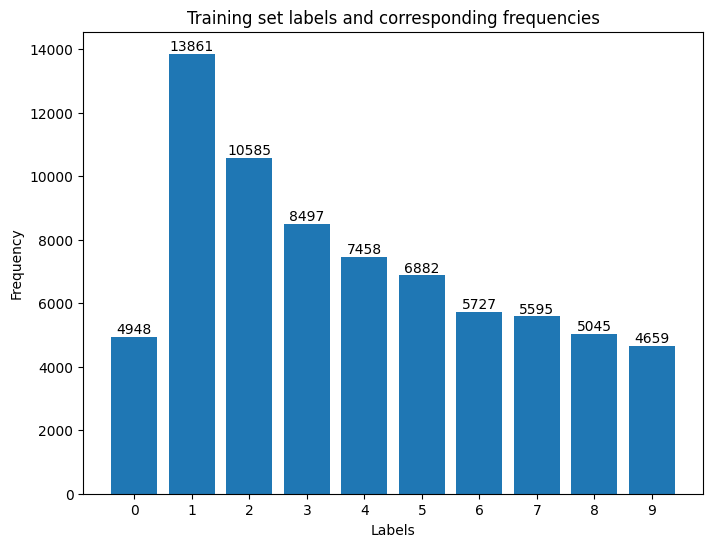

In [ ]:
# TRAIN Data
plt.figure(figsize=(8,6))
x_axis = list(train_dataset_dict.keys())
y_axis = list(train_dataset_dict.values())

train_bar_plt = plt.bar(x_axis, y_axis)

plt.title('Training set labels and corresponding frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(x_axis)
for bar in train_bar_plt:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height + 100, height, ha='center')

plt.show()

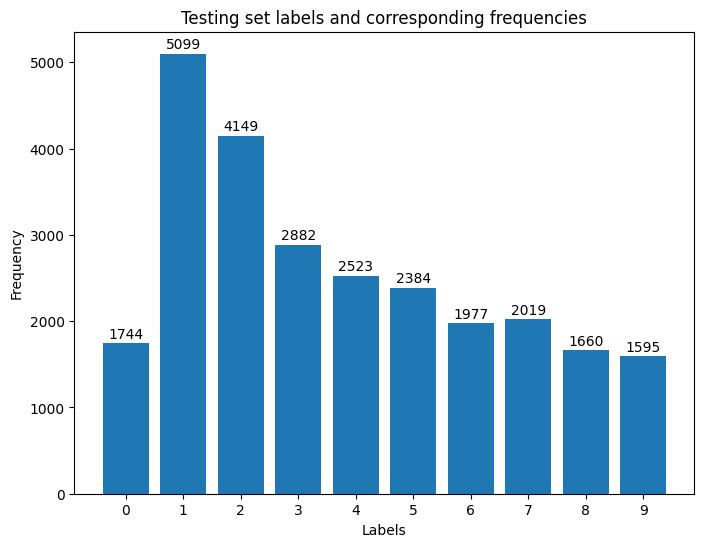

In [ ]:
# TEST Data
plt.figure(figsize=(8,6))
x_axis = list(test_dataset_dict.keys())
y_axis = list(test_dataset_dict.values())

test_bar_plt = plt.bar(x_axis, y_axis)

plt.title('Testing set labels and corresponding frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(x_axis)
for bar in test_bar_plt:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height + 60, height, ha='center')

plt.show()

### 1.2.3 Have equal spread of labels

As you have seen in the previous parts, some classes have much lower representation in the dataset than others; this might cause issues as our dataset is currently skewed, meaning that the classes do not all have an equally likely chance of being selected randomly. We will change that in this section.

We want **30,000** training images in our training data and **5,000** testing images in our testing data. In each dataset we want all our classes to have the same number of images.



In [ ]:
torch.manual_seed(42)

# get 30000 indices for training data, with
# an equal number of images for each class
train_indices = []

class_count = [[] for _ in range(10)]
for index, (image, label) in enumerate(train_dataset):
  if len(class_count[label]) < 3000:
    class_count[label].append(index)

train_indices = [indices for classes in class_count for indices in classes]

train_count_dict = dict()

In [ ]:
torch.manual_seed(42)

# get 5000 indices for testing data, with
# an equal number of images for each class
test_indices = []

class_count = [[] for _ in range(10)]
for index, (image, label) in enumerate(test_dataset):
  if len(class_count[label]) < 500:
    class_count[label].append(index)

test_indices = [indices for classes in class_count for indices in classes]

test_count_dict = dict()

In [ ]:
# create subsets of the training and testing data
from torch.utils.data import Subset
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

Create `train_subset_dict` and `test_subset_dict` using a similar process from 1.2.1

In [ ]:
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(train_dataset), shuffle=True, num_workers=0)
train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_dataset), shuffle=True, num_workers=0)

labels = []
for image, label in train_subset:
  labels.append(label)

train_subset_dict = Counter(labels)

labels = []
for image, label in test_subset:
  labels.append(label)

test_subset_dict = Counter(labels)

# verify the number of images are equal for every class

print(train_subset_dict)
print(test_subset_dict)

Counter({0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000, 6: 3000, 7: 3000, 8: 3000, 9: 3000})
Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500})


Now that we have `train_subset` and `test_subset`, let's create dataloaders using these two datasets.


In [ ]:
batch = 64

train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)

### 2.1.1 Logistic Regression Model Architecture

In [ ]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the neural network layers

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 3*32*32, out_features=10)


    def forward(self, x):
        # implement the operations on input data
        x = self.flatten(x)
        outputs = self.linear(x)

        return outputs

Let's print the model summary

In [ ]:
LogReg()

LogReg(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

### 2.1.2 Training Logistic Regression Model
---

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
# (1) instantiate the logistic regression to variable logreg, (2) set the loss criterion as CrossEntropyLoss
logreg = LogReg().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(logreg.parameters(), lr=1e-4) #lr - learning step
epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Logistic Regression
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = logreg(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_log
  accuracy = correct / total * 100
  acc_LIST_log.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_log
  loss_LIST_log.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.296231437593635, Accuracy = 15.056666666666665
The loss for Epoch 1 is: 2.25276926077251, Accuracy = 19.836666666666666
The loss for Epoch 2 is: 2.238241804688216, Accuracy = 21.12333333333333
The loss for Epoch 3 is: 2.2287371977051693, Accuracy = 22.12
The loss for Epoch 4 is: 2.222709144356408, Accuracy = 22.75
The loss for Epoch 5 is: 2.216964962131687, Accuracy = 23.236666666666668
The loss for Epoch 6 is: 2.2141300879561823, Accuracy = 23.353333333333335
The loss for Epoch 7 is: 2.2117150589855497, Accuracy = 23.84
The loss for Epoch 8 is: 2.2053311669241897, Accuracy = 24.21666666666667
The loss for Epoch 9 is: 2.202835450040252, Accuracy = 24.240000000000002
CPU times: user 1min 36s, sys: 1.71 s, total: 1min 38s
Wall time: 1min 45s


### 2.1.3 Plotting Training Accuracy vs Epochs for Logistic Regression

---

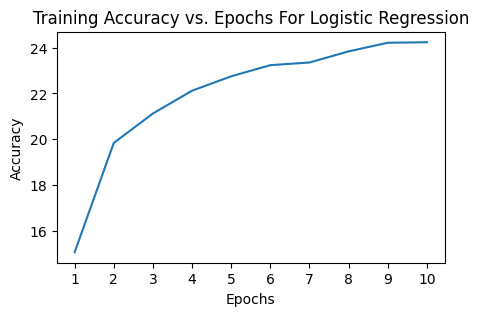

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,3))
plt.plot(range(1, len(acc_LIST_log)+1), acc_LIST_log)
plt.xticks(range(1, len(acc_LIST_log)+1))
plt.title('Training Accuracy vs. Epochs For Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### 2.1.4 Logistic Regression Model Accuracy

Calculate the Test Accuracy for the Logistic Regression Model we trained above.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs=logreg(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Calculate test accuracy for logistic regression (should multiple by 100)
test_acc_log = correct / total * 100
test_acc_log = torch.tensor(test_acc_log)

print('Test Accuracy: ' + str(test_acc_log.item()))

Test Accuracy: 18.239999771118164



Since logistic regression isn't that great at the classification problem above, we need more representation power in our model. We will now define a feedforward neural network.

For this section, we're going to first create three different types of data inputs to analyze the performance in each.



1.   First, we're going to analyze how well the *FNN* model will perform for a data input that only inludes data for the **red pixel values**. Since the shape of each one of our samples is (3, 32, 32), we're going to condense this down to (1, 32, 32) using a model architecture that can handle this new shape.
2.   Second, we're going to analyze the performance of an *FNN* model on a data input that only includes data for the **grayscale values** of the image. As a reminder, the grayscale value of a pixel are calculated from the the average of the red, green, and blue pixel values. The shape of each sample should be (1, 32, 32)
3. Finally, we'll use all of our inputs without modification to see how our *FNN* model performs with all data. We'll need to create a different architecture to handle the different sample size, but the original data loaders can be used.


### 2.2.1 FNN Preprocessing Helper Functions


### 2.2.1 Feedforward Neural Network Model Architecture

In [ ]:
def raw_sample_to_red(sample):
  # Convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the red values

  return sample[:, 0, :, :].unsqueeze(1)

def raw_sample_to_grayscale(sample):
  # Convert an input tensor of shape (batch_size, 3, 32, 32) to just contain the grey scale values
  return sample.mean(dim=1).unsqueeze(1)

### 2.2.2 Feedforward Neural Network Model Architecture


In [ ]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the neural network layers
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(in_features=1*32*32, out_features=256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        # implement the operations on input data
        x = self.flatten(x)
        x = self.relu(self.hidden(x))
        outputs = self.output(x)

        return outputs

Let's print the model summary

In [ ]:
FNN()

FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)

### 2.2.3 Training FNN Model
---

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
fnn_red = FNN().to(device)
# Step 1: instantiate the FNN model to variable fnn_red

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn_red.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_red = []
loss_LIST_FNN_red = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data (use helper)
      inputs = raw_sample_to_red(inputs)
      outputs = fnn_red(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN_red
  accuracy = correct / total * 100
  acc_LIST_FNN_red.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN_red
  loss_LIST_FNN_red.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.021026344441656, Accuracy = 37.21
The loss for Epoch 1 is: 1.4797830391031848, Accuracy = 59.92333333333333
The loss for Epoch 2 is: 1.2382403342708597, Accuracy = 65.73
The loss for Epoch 3 is: 1.115596594332632, Accuracy = 68.18666666666667
The loss for Epoch 4 is: 1.0345578562222055, Accuracy = 70.25333333333333
The loss for Epoch 5 is: 0.9744725578121031, Accuracy = 71.93666666666667
The loss for Epoch 6 is: 0.9235799405366373, Accuracy = 73.31333333333333
The loss for Epoch 7 is: 0.8822078901186172, Accuracy = 74.31
The loss for Epoch 8 is: 0.8458899685314724, Accuracy = 75.35333333333334
The loss for Epoch 9 is: 0.8127181669796454, Accuracy = 76.43666666666667
CPU times: user 1min 32s, sys: 512 ms, total: 1min 32s
Wall time: 1min 33s


Let's create a second training loop, but this time, we'll use our grayscale helper instead.

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
fnn_gray = FNN().to(device)
# Step 1: instantiate the FNN model to variable fnn_gray

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn_gray.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN_gray = []
loss_LIST_FNN_gray = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data (use helper)
      inputs = raw_sample_to_grayscale(inputs)
      outputs = fnn_gray(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN_gray
  accuracy = correct / total * 100
  acc_LIST_FNN_gray.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN_gray
  loss_LIST_FNN_gray.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 2.0350832756140083, Accuracy = 37.31
The loss for Epoch 1 is: 1.4858317466687039, Accuracy = 61.25666666666667
The loss for Epoch 2 is: 1.2350666070543628, Accuracy = 65.92666666666666
The loss for Epoch 3 is: 1.110023232284131, Accuracy = 68.66333333333333
The loss for Epoch 4 is: 1.0306297277590868, Accuracy = 70.56666666666666
The loss for Epoch 5 is: 0.9697433774913552, Accuracy = 72.21666666666667
The loss for Epoch 6 is: 0.9178314116209555, Accuracy = 73.71333333333332
The loss for Epoch 7 is: 0.8750869866881543, Accuracy = 74.82
The loss for Epoch 8 is: 0.8368122908098103, Accuracy = 75.98333333333333
The loss for Epoch 9 is: 0.8017114909218827, Accuracy = 77.16333333333333
CPU times: user 1min 33s, sys: 525 ms, total: 1min 34s
Wall time: 1min 34s


### 2.2.4 Feed Forward Network on Raw Inputs Architecture


Finally, let's see how the model fares with the normal raw inputs.

In [ ]:
class FNN_RAW(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the neural network layers
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(in_features=3*32*32, out_features=256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        # implement the operations on input data
        x = self.flatten(x)
        x = self.relu(self.hidden(x))
        outputs = self.output(x)

        return outputs

Let's print the model summary

In [ ]:
FNN_RAW()

FNN_RAW(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=3072, out_features=256, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
%%time
# Sending the data to device (CPU or GPU)
fnn = FNN_RAW().to(device)
# Step 1: instantiate the FNN model to variable fnn

# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(fnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = fnn(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and add to correct and total
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch and add to acc_LIST_FNN
  accuracy = correct / total * 100
  acc_LIST_FNN.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_FNN
  loss_LIST_FNN.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 1.787166121163602, Accuracy = 44.87
The loss for Epoch 1 is: 1.212209277696955, Accuracy = 65.5
The loss for Epoch 2 is: 1.039955743213198, Accuracy = 70.03666666666668
The loss for Epoch 3 is: 0.9384641515166521, Accuracy = 72.72
The loss for Epoch 4 is: 0.8678655948466075, Accuracy = 74.67333333333333
The loss for Epoch 5 is: 0.8087310717939568, Accuracy = 76.50666666666666
The loss for Epoch 6 is: 0.7584578122284367, Accuracy = 78.26666666666667
The loss for Epoch 7 is: 0.7167351860989893, Accuracy = 79.36666666666666
The loss for Epoch 8 is: 0.6804277175652192, Accuracy = 80.33333333333333
The loss for Epoch 9 is: 0.6483465691746425, Accuracy = 81.49
CPU times: user 1min 31s, sys: 547 ms, total: 1min 32s
Wall time: 1min 32s


### 2.2.5 Plotting Training Accuracy vs Epochs FNN

---


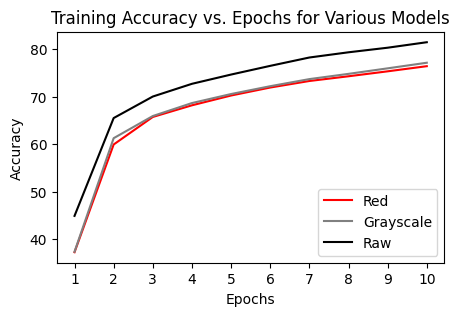

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,3))
plt.plot(range(1, len(acc_LIST_FNN_red)+1), acc_LIST_FNN_red, color='red', label = 'Red')
plt.plot(range(1, len(acc_LIST_FNN_red)+1), acc_LIST_FNN_gray, color='gray', label = 'Grayscale')
plt.plot(range(1, len(acc_LIST_FNN_red)+1), acc_LIST_FNN, color='black', label = 'Raw')
plt.xticks(range(1, len(acc_LIST_FNN_red)+1))

plt.title('Training Accuracy vs. Epochs for Various Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2.2.6 FNN Model Accuracy

In [ ]:
total = 0
correct_fnn = 0
correct_fnn_red = 0
correct_fnn_gray = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        red_images = raw_sample_to_red(images)
        red_output = fnn_red(red_images)

        gray_images = raw_sample_to_grayscale(images)
        gray_output = fnn_gray(gray_images)

        output = fnn(images)
        # Get the prediction using argmax
        _, red_predicted = torch.max(red_output.data, 1)
        _, gray_predicted = torch.max(gray_output.data, 1)
        _, predicted = torch.max(output.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct_fnn_red += (red_predicted == labels).sum().item()
        correct_fnn_gray += (gray_predicted == labels).sum().item()
        correct_fnn += (predicted == labels).sum().item()

# Calculate test accuracy for FNN (should multiple by 100)
test_acc_FNN_red = torch.tensor(correct_fnn_red / total * 100)
test_acc_FNN_gray = torch.tensor(correct_fnn_gray / total * 100)
test_acc_FNN = torch.tensor(correct_fnn / total * 100)

print('Test Accuracy (Red Values Only): ' + str(test_acc_FNN_red.item()))
print('Test Accuracy (Grayscale Values Only): ' + str(test_acc_FNN_gray.item()))
print('Test Accuracy (All Values): ' + str(test_acc_FNN.item()))

Test Accuracy (Red Values Only): 70.9800033569336
Test Accuracy (Grayscale Values Only): 71.5999984741211
Test Accuracy (All Values): 74.76000213623047


##2.3 Convolutional Neural Networks

### 2.3.0 Calculating Output Dimensions of Convolution and Pooling Layers

In [ ]:
import math

def feature_map_dim(input_dim, padding, kernel_size, stride):
  '''
  The function takes in the following four parameters and return the dimension of the output feature map.

  input_dim: height/width of the input image
  kernel_size: size of the convolving kernel (aka. filter)
  padding: padding added to all four sides of the input in order to preserve the edges/borders
  stride: Stride of the convolution, or how many shifts per kernel

  ROUND DOWN.

  set dilation to 1
  '''
  dilation = 1
  output_dim = math.floor((((input_dim + 2 * padding - dilation * (kernel_size - 1) - 1) / (stride)) + 1))
  return output_dim

### 2.3.1 Create custom Convolutional Neural Network Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        after_conv1_dim = feature_map_dim(32, padding=1, kernel_size=3, stride=1)
        after_pool1_dim = feature_map_dim(after_conv1_dim, padding=0, kernel_size=2, stride=2)
        after_conv2_dim = feature_map_dim(after_pool1_dim, padding=1, kernel_size=3, stride=1)
        after_pool2_dim = feature_map_dim(after_conv2_dim, padding=0, kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=after_pool2_dim * after_pool2_dim * 64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
      x = self.pool(self.relu(self.conv1(x)))
      x = self.pool(self.relu(self.conv2(x)))
      x = self.flatten(x)
      x = self.relu(self.fc1(x))
      outputs = self.fc2(x)
      return outputs

In [ ]:
CNN()

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 2.3.2 Training CNN Model
---

In [ ]:
%%time
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4) #lr - learning step
epoch = 10
acc_LIST_CNN = []
loss_LIST_CNN = []
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = cnn(inputs)
      _, predicted = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = correct / total * 100
  acc_LIST_CNN.append(accuracy)
  loss_LIST_CNN.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 1.982753707401788, Accuracy = 33.776666666666664
The loss for Epoch 1 is: 0.9938114798907787, Accuracy = 72.06666666666666
The loss for Epoch 2 is: 0.7607393489717674, Accuracy = 78.41666666666667
The loss for Epoch 3 is: 0.6679986395053009, Accuracy = 81.32333333333334
The loss for Epoch 4 is: 0.6174856368730317, Accuracy = 82.75333333333333
The loss for Epoch 5 is: 0.576341836691411, Accuracy = 84.01333333333334
The loss for Epoch 6 is: 0.5469494249774958, Accuracy = 84.71666666666667
The loss for Epoch 7 is: 0.5214236894967967, Accuracy = 85.41333333333333
The loss for Epoch 8 is: 0.4989251052138648, Accuracy = 85.96333333333334
The loss for Epoch 9 is: 0.478611333061383, Accuracy = 86.52666666666666
CPU times: user 1min 39s, sys: 950 ms, total: 1min 40s
Wall time: 1min 44s


### 2.3.3 Plotting Training Accuracy vs Epochs CNN

---


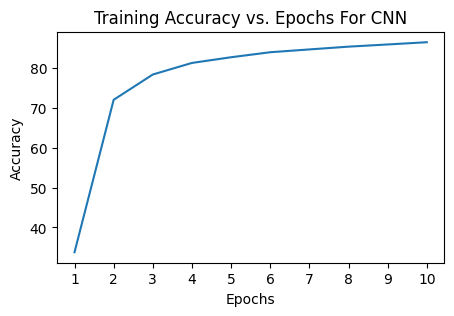

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,3))
plt.plot(range(1, len(acc_LIST_CNN)+1), acc_LIST_CNN)
plt.xticks(range(1, len(acc_LIST_CNN)+1))
plt.title('Training Accuracy vs. Epochs For CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### 2.3.4 CNN Model Test Accuracy


In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = cnn(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy for CNN
test_acc_CNN = torch.tensor(correct / total * 100)

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 81.68000030517578


### 2.3.5 CNN Hyperparameter Tuning

In this section, we will now explore how we can find an "optimal" Convolutional Neural Network architecture by tuning some hyperparameters. For this section, we will particularly focus on the `learning rate`, `beta1`, `beta2` and `number of fully connected layers`.

Create a new model that will be used in the hyperparameter tuning.

In [ ]:
# Create a new model CNNTuned whose hyperaparameters we will tune
class CNNTuned(nn.Module):
    def __init__(self, ff_layers = 3):
        super().__init__()

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        after_conv1_dim = feature_map_dim(32, padding=1, kernel_size=3, stride=1)
        after_pool1_dim = feature_map_dim(after_conv1_dim, padding=0, kernel_size=2, stride=2)
        after_conv2_dim = feature_map_dim(after_pool1_dim, padding=1, kernel_size=3, stride=1)
        after_pool2_dim = feature_map_dim(after_conv2_dim, padding=0, kernel_size=2, stride=2)

        self.ff_layers = nn.ModuleList()
        input_dim = after_pool2_dim * after_pool2_dim * 64

        for i in range(ff_layers - 1):
          self.ff_layers.append(nn.Linear(input_dim, input_dim // 2))
          input_dim = input_dim // 2

        self.ff_layers.append(nn.Linear(in_features=input_dim, out_features=10))

    def forward(self, x):

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        for layer in self.ff_layers[:-1]:
          x = self.relu(layer(x))

        outputs = self.ff_layers[-1](x)
        return outputs

The way we will tune these hyperparameters is by conducting a gridsearch on these various hyperparameters.

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'betas': [(0.9, 0.999), (0.95, 0.995), (0.99, 0.99)],
    'num_layers': [2, 3, 4],
}

pgrid = ParameterGrid(param_grid)

num_epochs = 5

In [ ]:
# Conduct grid search.
# PICKING BEST ONE JUST ON ACCURACY
def cnn_train(model, train_loader, optimizer, num_epochs):
  best_accuracy = 0
  for epoch in range(num_epochs):
    correct = 0
    total = 0
    for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor)
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    if accuracy > best_accuracy:
      best_accuracy = accuracy

  return best_accuracy

best_params = None
best_accuracy = 0

for params in pgrid:
  model = CNNTuned(ff_layers = params['num_layers']).to(device)
  optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], betas=params['betas'])
  criterion = nn.CrossEntropyLoss()

  accuracy = cnn_train(model, train_loader, optimizer, num_epochs)

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_params = params

print(best_accuracy)
print(best_params)

94.36666666666666
{'betas': (0.9, 0.999), 'learning_rate': 0.0005, 'num_layers': 3}


Now that we ran the grid search, we find the best hyperparameters and use them to train the model.

In [ ]:
%%time

acc_LIST_CNN_TUNE = []
loss_LIST_CNN_TUNE = []

# Train the CNN

# %%time

cnn_tune = CNNTuned(ff_layers = 3).to(device)
# Step 2: set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn_tune.parameters(), lr=0.0005, betas=(0.9, 0.999)) #lr - learning step
epoch = 10

# Train the CNN
for epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      # Step 1: Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()
      # Step 2: Feed the network the train data
      outputs = cnn_tune(inputs)
      # Step 3: Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)
      # Step 4: Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)
      # Step 5: Do a back propagation
      loss.backward()
      # Step 6: Update the weight using the gradients from back propagation by learning step
      optimizer.step()
      # Step 7: Get loss and add to accumulated loss for each epoch
      running_loss += loss.item()
      # Step 8: Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  # Step 9: Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_CNN
  accuracy = correct / total * 100
  acc_LIST_CNN_TUNE.append(accuracy)
  # Step 10: Get average loss for each epoch and add to loss_LIST_CNN
  loss_LIST_CNN_TUNE.append(running_loss / len(train_loader))

  # print statistics
  print("The loss for Epoch {} is: {}, Accuracy = {}".format(epoch, running_loss/len(train_loader), accuracy))

The loss for Epoch 0 is: 1.0481821120357209, Accuracy = 65.11
The loss for Epoch 1 is: 0.46330294988429876, Accuracy = 85.96333333333334
The loss for Epoch 2 is: 0.33478991115398243, Accuracy = 89.76333333333332
The loss for Epoch 3 is: 0.23901698561206555, Accuracy = 92.99666666666667
The loss for Epoch 4 is: 0.1645985536420269, Accuracy = 95.08
The loss for Epoch 5 is: 0.10603305414668533, Accuracy = 96.82
The loss for Epoch 6 is: 0.08030042181641403, Accuracy = 97.59333333333333
The loss for Epoch 7 is: 0.0597198557958547, Accuracy = 98.14
The loss for Epoch 8 is: 0.03781643252162489, Accuracy = 98.88333333333334
The loss for Epoch 9 is: 0.036885727201648025, Accuracy = 98.79333333333334
CPU times: user 2min, sys: 583 ms, total: 2min 1s
Wall time: 2min 1s


Now, let's run the new model on the test data and gauge its performance.

In [ ]:
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor) # Cast to Float
        images, labels = images.to(device), labels.to(device)

        # Get the output
        outputs = cnn_tune(images)
        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)
        # Get number of correct prediction and add to correct and total
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Calculate test accuracy for CNN
test_acc_CNN = torch.tensor(100 * correct / total)

print(f'Test Accuracy: ' + str(test_acc_CNN.item()))

Test Accuracy: 86.05999755859375


## 2.4. Reflection



Let's compare the model performance:

In [ ]:
print(f'Test Accuracy for Logistic Regression: ' + str(test_acc_log.item()))
print(f'Test Accuracy for FNN: ' + str(test_acc_FNN.item()))
print(f'Test Accuracy for CNN: ' + str(test_acc_CNN.item()))

Test Accuracy for Logistic Regression: 18.239999771118164
Test Accuracy for FNN: 74.76000213623047
Test Accuracy for CNN: 86.05999755859375


### 2.5.1 Creating Confusion Matrix

---

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def cm_generator(test_loader):

  # The goal is to obtain two lists of prediction and actual labels.
  # Then, using these two lists, create a confusion matrix dataframe
  prediction_list = []
  actual_list = []
  with torch.no_grad():
      for images, labels in test_loader:
          labels = labels.type(torch.LongTensor)
          images, labels = images.to(device), labels.to(device)

          outputs = cnn_tune(images)

          _, predicted = torch.max(outputs.data, 1)

          prediction_list.extend(predicted.cpu().numpy())
          actual_list.extend(labels.cpu().numpy())

  con_matrix = confusion_matrix(actual_list, prediction_list)
  return pd.DataFrame(con_matrix)

confusion_matrix_df = cm_generator(test_loader)

### 2.5.2 Visualizing Confusion Matrix

---

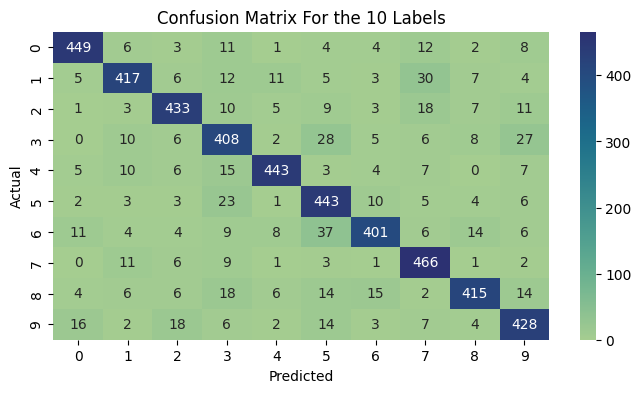

In [ ]:
plt.figure(figsize=(8,4))
sns.heatmap(confusion_matrix_df, annot=True, cmap='crest', fmt = 'g')
plt.title('Confusion Matrix For the 10 Labels')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()